**Name:** Luan Minh Tran

**NetID:** lmt185

**RUID:** 197002611

### Problem Statement
Fine-tune the ResNet 18 network to
classify the MNIST dataset. Report the confusion matrix, the accuracy, the f-score,
precision and recall of your classifier.

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import time
import copy
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [4]:
# cd gdrive/My Drive/Computer Vision/Projects

/content/gdrive/My Drive/Computer Vision/Projects


In [4]:
!ls

gdrive	model.pt  sample_data  sampleSubmission.csv  test1  train


In [5]:
!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 78.9MB/s]
 98% 535M/543M [00:02<00:00, 239MB/s]
100% 543M/543M [00:02<00:00, 192MB/s]
 98% 265M/271M [00:02<00:00, 114MB/s] 
100% 271M/271M [00:02<00:00, 98.5MB/s]


In [7]:
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       
  inflating: train/dog.5520.jpg      
  inflating: train/dog.5521.jpg      
  inflating: train/dog.5522.jpg      

In [5]:
# train_dir = '/content/gdrive/My Drive/Computer Vision/Projects/train'
# test_dir = '/content/gdrive/My Drive/Computer Vision/Projects/test1'
train_dir = '/content/train'
test_dir = '/content/test1'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [8]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]
        
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    transforms.ToTensor()
])

cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]

cats = CatDogDataset(cat_files, train_dir, transform = transform)
dogs = CatDogDataset(dog_files, train_dir, transform = transform)

catdogs = ConcatDataset([cats, dogs])
indices = list(range(len(catdogs)))
np.random.shuffle(indices)
split = int(np.floor(0.2*len(catdogs)))

train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

trainloader = DataLoader(catdogs, batch_size = 64, sampler= train_sample)
validloader = DataLoader(catdogs, batch_size = 64, sampler= valid_sample)

testset = CatDogDataset(test_files, test_dir, mode='test', transform = transform)
testloader = DataLoader(testset, batch_size = 64, shuffle=True)


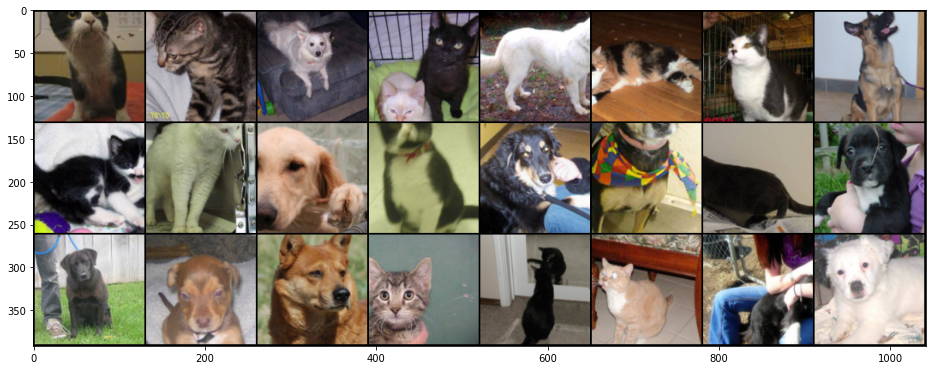

In [9]:
samples, labels = iter(testloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

# ResNet18

In [10]:
class MyResNet(nn.Module):

    def __init__(self, in_channels=3):
        super(MyResNet, self).__init__()

        # bring resnet
        self.model = torchvision.models.resnet18(pretrained=True)

        # original definition of the first layer on the renset class
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # your case
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
      
    def forward(self, x):
        return self.model(x)


In [11]:
# TODO: Load pretrained model
# TODO: Update network to handle different number of output classes
# TODO: Create an optimizer to update weights of the network
device = 'cuda'

model = MyResNet()

model = model.to(device)

# criterion = nn.KLDivLoss()
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.002, momentum=0.8)
# optimizer_ft = optim.Adadelta(model_ft.parameters(), lr=0.002, rho=0.9, eps=1e-06, weight_decay=0)



In [12]:
# TODO: Train on MNIST dataset
def train_model(model, criterion, optimizer, epochs):
    train_loss =[]
    valid_loss = []
    valid_loss_min = np.Inf
    for e in range(epochs):
        running_loss = 0
        v_loss = 0
      
        for images, labels in trainloader:
          images, labels = images.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()*images.size(0)

        for images, labels in validloader:
          images, labels = images.to(device), labels.to(device)
          outputs_val = model(images)
          loss = criterion(outputs_val,labels)

          v_loss += loss.item()*images.size(0)

        tra_loss = running_loss / len(trainloader.sampler)
        val_loss = v_loss / len(validloader.sampler)

            # scheduler.step()
        print("Epoch : {}/{}..".format(e+1,epochs),
         "Training Loss: {:.6f}".format(tra_loss),
         "Validation Loss: {:.6f}".format(val_loss)) 
        train_loss.append(tra_loss)
        valid_loss.append(val_loss)

        if val_loss < valid_loss_min:
          torch.save(model.state_dict(),'model.pt')
          valid_loss_min = val_loss

    plt.plot(train_loss,label="Training Loss")
    plt.plot(valid_loss,label="Validation Loss")
    plt.legend()
    plt.show()

    return model 

Epoch : 1/15.. Training Loss: 1.481770 Validation Loss: 0.593615
Epoch : 2/15.. Training Loss: 0.533146 Validation Loss: 0.515983
Epoch : 3/15.. Training Loss: 0.449894 Validation Loss: 0.462715
Epoch : 4/15.. Training Loss: 0.392552 Validation Loss: 0.428439
Epoch : 5/15.. Training Loss: 0.348542 Validation Loss: 0.415493
Epoch : 6/15.. Training Loss: 0.315604 Validation Loss: 0.378218
Epoch : 7/15.. Training Loss: 0.282055 Validation Loss: 0.372388
Epoch : 8/15.. Training Loss: 0.274099 Validation Loss: 0.354754
Epoch : 9/15.. Training Loss: 0.227565 Validation Loss: 0.344730
Epoch : 10/15.. Training Loss: 0.209282 Validation Loss: 0.335954
Epoch : 11/15.. Training Loss: 0.187164 Validation Loss: 0.355023
Epoch : 12/15.. Training Loss: 0.187786 Validation Loss: 0.336708
Epoch : 13/15.. Training Loss: 0.173465 Validation Loss: 0.322206
Epoch : 14/15.. Training Loss: 0.156678 Validation Loss: 0.319379
Epoch : 15/15.. Training Loss: 0.145114 Validation Loss: 0.309136


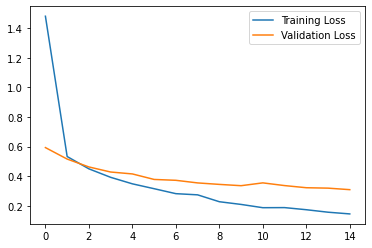

In [13]:
model = train_model(model,criterion, optimizer_ft, epochs=15)

In [14]:
model.eval()
fn_list = []
pred_list = []
for images, fn in testloader:
    with torch.no_grad():
        images = images.to(device)
        output = model(images)
        pred = torch.argmax(output, dim=1)
        fn_list += [n[:-4] for n in fn]
        pred_list += [p.item() for p in pred]

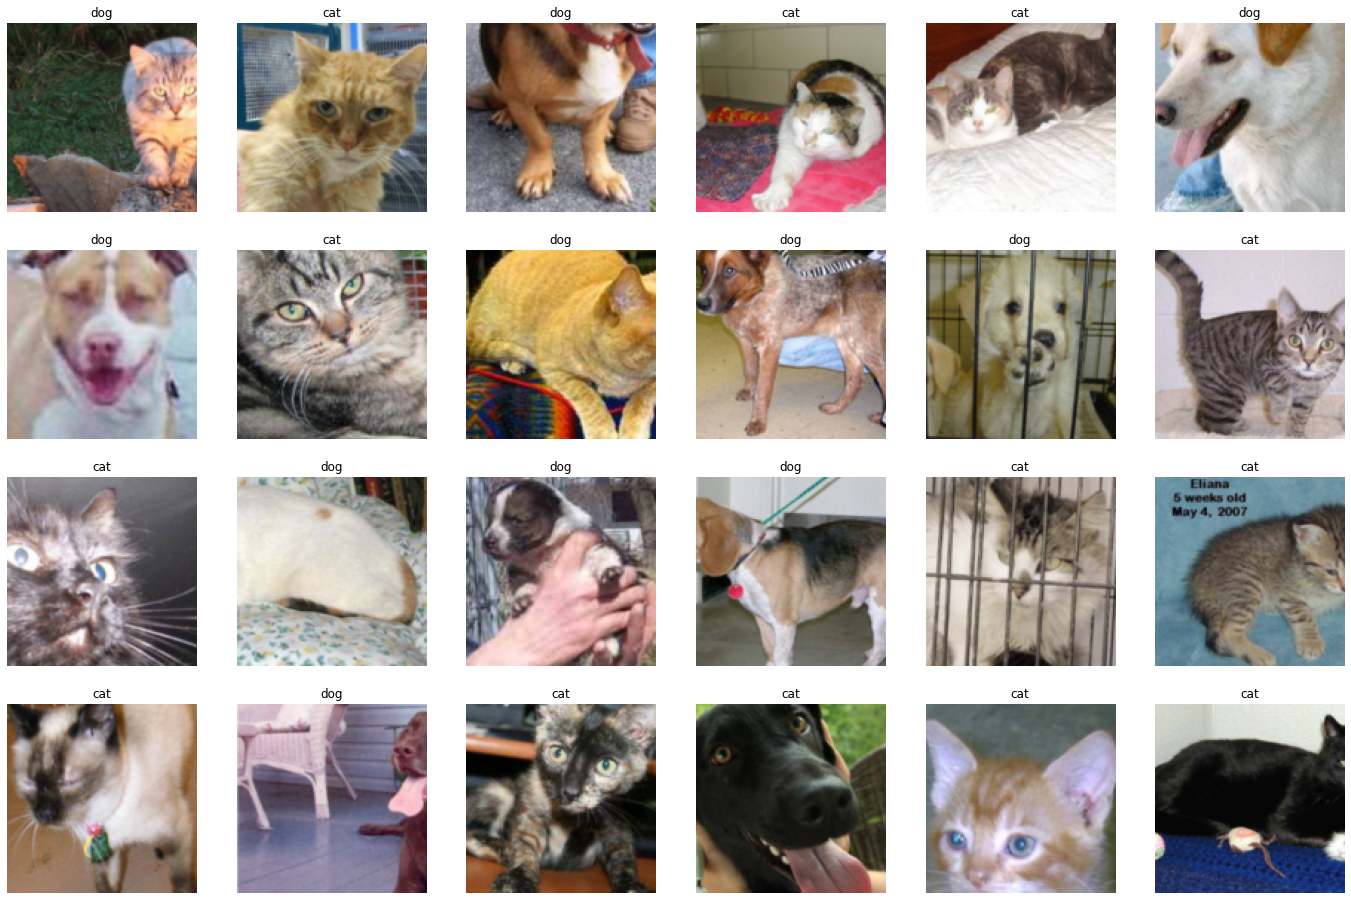

In [21]:
samples, _ = iter(testloader).next()
samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))

In [24]:
class MyVGGNet(nn.Module):

    def __init__(self, in_channels=3):
        super(MyVGGNet, self).__init__()

        # bring resnet
        self.model = torchvision.models.vgg16(pretrained=True)

        # original definition of the first layer on the renset class
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # your case
        # self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(512, 2)
    def forward(self, x):
        return self.model(x)

In [25]:
model_2 = MyVGGNet()

model_2 = model_2.to(device)

# criterion = nn.KLDivLoss()
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_2.parameters(), lr=0.002, momentum=0.8)
# optimizer_ft = optim.Adadelta(model_ft.parameters(), lr=0.002, rho=0.9, eps=1e-06, weight_decay=0)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Epoch : 1/15.. Training Loss: 1.391214 Validation Loss: 0.739395
Epoch : 2/15.. Training Loss: 0.657013 Validation Loss: 0.975612
Epoch : 3/15.. Training Loss: 0.608382 Validation Loss: 0.550590
Epoch : 4/15.. Training Loss: 0.492305 Validation Loss: 0.429353
Epoch : 5/15.. Training Loss: 0.456014 Validation Loss: 0.354513
Epoch : 6/15.. Training Loss: 0.388419 Validation Loss: 0.343808
Epoch : 7/15.. Training Loss: 0.331645 Validation Loss: 0.308773
Epoch : 8/15.. Training Loss: 0.269908 Validation Loss: 0.349761
Epoch : 9/15.. Training Loss: 0.249118 Validation Loss: 0.268035
Epoch : 10/15.. Training Loss: 0.257566 Validation Loss: 0.354379
Epoch : 11/15.. Training Loss: 0.211536 Validation Loss: 0.719014
Epoch : 12/15.. Training Loss: 0.212150 Validation Loss: 0.283680
Epoch : 13/15.. Training Loss: 0.181690 Validation Loss: 0.174749
Epoch : 14/15.. Training Loss: 0.151717 Validation Loss: 0.209475
Epoch : 15/15.. Training Loss: 0.145357 Validation Loss: 0.275240


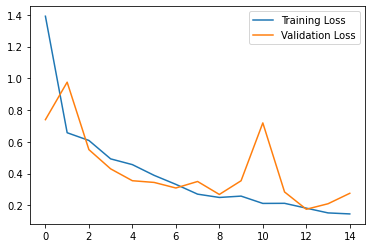

In [26]:
model_2 = train_model(model_2,criterion, optimizer_ft, epochs=15)

In [27]:
model_2.eval()
fn_list = []
pred_list = []
for images, fn in testloader:
    with torch.no_grad():
        images = images.to(device)
        output = model_2(images)
        pred = torch.argmax(output, dim=1)
        fn_list += [n[:-4] for n in fn]
        pred_list += [p.item() for p in pred]

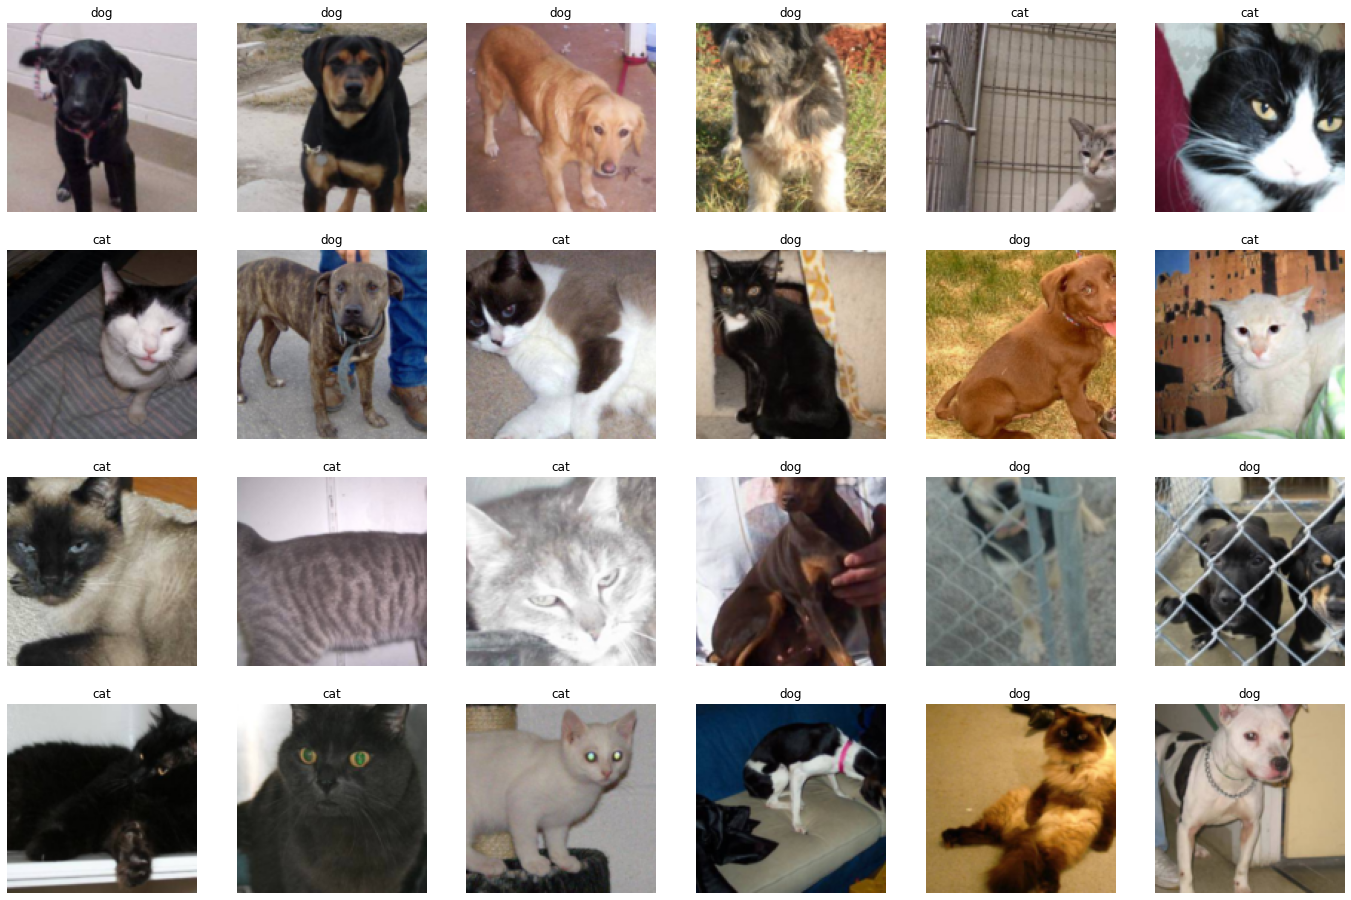

In [28]:
samples, _ = iter(testloader).next()
samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model_2(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))